In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [2]:
NO_OF_CLASSES = 7
IMG_SIZE = 224

In [3]:
# Create the base model from the pre-trained model MobileNetV2.
base_model = keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), 
                                            include_top=False,         # Dont include classifier for 1000 classes.
                                            weights='imagenet')

base_model.summary()



Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv

In [4]:
model = keras.Sequential(name="EmoSenseNet")
model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dense(64, activation="relu"))
model.add(keras.layers.Dense(NO_OF_CLASSES, activation="softmax"))

model.summary()

Model: "EmoSenseNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2430663 (9.27 MB)
Trainable params: 23965

In [5]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics=['accuracy'])

In [6]:
train_path = "FER-2013/train"
test_path = "FER-2013/test"

# Given preprossing function transforms intensity values between -1 to 1.
train_data_generator = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input, 
                                          rotation_range=5, 
                                          width_shift_range=0.1, 
                                          height_shift_range=0.1, 
                                          horizontal_flip=True)

test_data_generator = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input)

In [7]:
train_batches = train_data_generator.flow_from_directory(directory=train_path, 
                                                         target_size=(IMG_SIZE, IMG_SIZE), 
                                                         batch_size=32, 
                                                         color_mode="rgb", 
                                                         class_mode="sparse", 
                                                         shuffle=True)

test_batches = test_data_generator.flow_from_directory(directory=test_path, 
                                                       target_size=(IMG_SIZE, IMG_SIZE), 
                                                       batch_size=32, 
                                                       color_mode="rgb",
                                                       class_mode="sparse", 
                                                       shuffle=False)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [8]:
# Create a directory to save models
save_dir = 'Saved_Models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define the ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, "EmoSenseNet_epoch_{epoch:02d}.h5")
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             save_weights_only=True, 
                                             save_best_only=False,
                                             save_freq='epoch')  # Save after every epoch.


In [9]:
history = model.fit(train_batches,
                    epochs=30, 
                    validation_data=test_batches, 
                    callbacks=[checkpoint])

Epoch 1/30


898/898 [==============================] - 1290s 1s/step - loss: 1.2710 - accuracy: 0.5188 - val_loss: 5.8906 - val_accuracy: 0.1549
Epoch 2/30
898/898 [==============================] - 1151s 1s/step - loss: 1.1052 - accuracy: 0.5860 - val_loss: 3.5268 - val_accuracy: 0.2675
Epoch 3/30
898/898 [==============================] - 1363s 2s/step - loss: 1.0496 - accuracy: 0.6082 - val_loss: 4.2498 - val_accuracy: 0.2274
Epoch 4/30
898/898 [==============================] - 1167s 1s/step - loss: 1.0042 - accuracy: 0.6241 - val_loss: 2.3448 - val_accuracy: 0.4345
Epoch 5/30
898/898 [==============================] - 1055s 1s/step - loss: 0.9647 - accuracy: 0.6403 - val_loss: 1.9122 - val_accuracy: 0.4656
Epoch 6/30
898/898 [==============================] - 1035s 1s/step - loss: 0.9444 - accuracy: 0.6513 - val_loss: 4.7641 - val_accuracy: 0.3058
Epoch 7/30
898/898 [==============================] - 1034s 1s/step - loss: 0.9091 - accuracy: 0.6612 - val_loss: 1.6003 - val_accurac

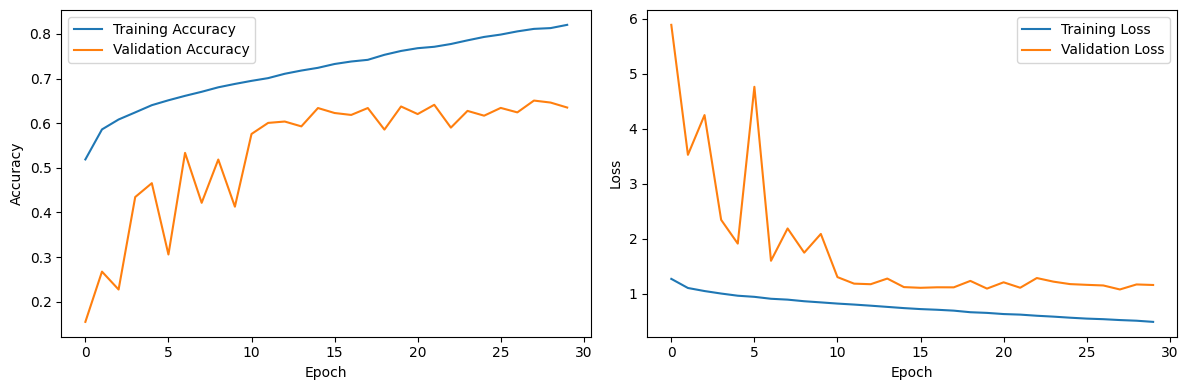

In [10]:
# Plot training accuracy and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Save model structure in json file.
model_json = model.to_json()
with open("EmoSenseNet.json", "w") as json_file:
    json_file.write(model_json)

# Save trained model weight in .h5 file.
model.save_weights('EmoSenseNet.h5')